In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm.sklearn import LGBMClassifier

import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from imblearn.over_sampling import SMOTE
from sklearn.base import clone, BaseEstimator, ClassifierMixin

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc

In [2]:
consump_df = pd.read_csv('../data/CS/Hubballi_Dhaward_Water_Consumption_Nightlight_Population.csv')

feature_df = pd.read_csv('../outputs/segmentation_result_cleaned.csv')
print("Number of HHs with availabel SVI:", feature_df.shape[0])

building_df = pd.read_csv('../data/CS/Hubballi_CS_building.csv') 

# Drop rows with missing building height
building_df = building_df.dropna(subset=['building_height'])

cs_building_df = pd.merge(consump_df, building_df, on='sl_no', how='left')
print("Number of HHs with in Customer Survey:", cs_building_df.shape[0])

df = pd.merge(feature_df, cs_building_df, on='sl_no', how='left')
print("Number of HHs with both CS and SVI:", df.shape[0])

Number of HHs with availabel SVI: 28114
Number of HHs with in Customer Survey: 35980
Number of HHs with both CS and SVI: 28114


In [3]:
df['monthly_family_income'].value_counts()

monthly_family_income
10-20K    14849
0-10K      6533
20-50K     5164
> 50K       582
Name: count, dtype: int64

In [4]:
df = df.rename(columns={'monthly_family_income': 'Target'})
# Drop rows with missing values in the 'Target' column
df = df.dropna(subset=['Target'])
df.shape

(27128, 95)

In [5]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123, shuffle=True, stratify=df['Target'])
train_df.shape

(21702, 95)

## Training Models
### Image Embedding + ML

In [6]:
# BASELINE 1: SATELLITE IMAGE EMBEDDING + ML

# Custom Dataset for feature extraction
class ImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, f"{self.dataframe.iloc[idx]['sl_no']}.jpg")
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)
        target = self.dataframe.iloc[idx]['Target']
        return image, target

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create datasets
train_satellite_dataset = ImageDataset(train_df, '../data/raw/Hubballi_Satellite', transform)
test_satellite_dataset = ImageDataset(test_df, '../data/raw/Hubballi_Satellite', transform)

train_street_dataset = ImageDataset(train_df, '../data/raw/Hubballi_Original', transform)
test_street_dataset = ImageDataset(test_df, '../data/raw/Hubballi_Original', transform)

# Create dataloaders
train_satellite_loader = DataLoader(train_satellite_dataset, batch_size=32, shuffle=False)
test_satellite_loader = DataLoader(test_satellite_dataset, batch_size=32, shuffle=False)

train_street_loader = DataLoader(train_street_dataset, batch_size=32, shuffle=False)
test_street_loader = DataLoader(test_street_dataset, batch_size=32, shuffle=False)

# Define feature extraction model
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        base_model = models.efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT')

        self.cnn = nn.Sequential(
            base_model.features,   # Keep feature extractor
            nn.AdaptiveAvgPool2d(1),  # Reduce spatial dimensions to (1,1)
            nn.Flatten(),  # Flatten the feature map
            nn.Linear(1280, 256)  # Reduce from 1280 to 256
        )

    def forward(self, x):
        x = self.cnn(x)  
        return x

# Extract features
def extract_features(data_loader, model, device):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device)
            outputs = model(images)
            features.append(outputs.cpu().numpy())
            labels.extend(targets)  # Using extend to handle list of targets
    return np.vstack(features), np.array(labels)

# Instantiate the model and extract features
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
feature_extractor = FeatureExtractor().to(device)

# Extract features for satellite and street view images
train_satellite_features, train_labels = extract_features(train_satellite_loader, feature_extractor, device)
test_satellite_features, test_labels = extract_features(test_satellite_loader, feature_extractor, device)

train_street_features, _ = extract_features(train_street_loader, feature_extractor, device)
test_street_features, _ = extract_features(test_street_loader, feature_extractor, device)


# Apply SMOTE to satellite features
smote = SMOTE(random_state=123)
train_satellite_features_resampled, train_labels_resampled = smote.fit_resample(train_satellite_features, train_labels)

# Apply SMOTE to street view features
train_street_features_resampled, train_street_labels_resampled = smote.fit_resample(train_street_features, train_labels)

# Print the resampled shapes for verification
print(f"Satellite Features Shape after SMOTE: {train_satellite_features_resampled.shape}")
print(f"Street View Features Shape after SMOTE: {train_street_features_resampled.shape}")

Satellite Features Shape after SMOTE: (47516, 256)
Street View Features Shape after SMOTE: (47516, 256)


In [7]:
# Combined satellite and street view features
train_combined_features = np.hstack((train_satellite_features_resampled, train_street_features_resampled))
test_combined_features = np.hstack((test_satellite_features, test_street_features))

In [8]:
def cross_val_evaluate_model(model, features, labels, cv, class_labels, legend_labels):
    # Create a StratifiedKFold object
    stratified_kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=123)

    # Cross-validation predictions with stratification
    preds = cross_val_predict(model, features, labels, cv=stratified_kfold, method='predict')
    probs = cross_val_predict(model, features, labels, cv=stratified_kfold, method='predict_proba')

    # Classification report
    print(classification_report(labels, preds, target_names=legend_labels))

    # Calculate ROC-AUC score
    y_true = pd.get_dummies(labels).values
    y_pred = pd.DataFrame(probs, columns=class_labels).values
    roc_auc = roc_auc_score(y_true, y_pred, multi_class='ovr')
    print(f"ROC-AUC Score: {roc_auc}")

    # ROC Curve for each class
    fpr = {}
    tpr = {}
    roc_auc_dict = {}

    for i, label in enumerate(legend_labels):
        fpr[label], tpr[label], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc_dict[label] = auc(fpr[label], tpr[label])

    plt.figure()
    for label, legend_label in zip(class_labels, legend_labels):
        plt.plot(fpr[legend_label], tpr[legend_label], label=f'{legend_label} (AUC = {roc_auc_dict[legend_label]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Each Class')
    plt.legend(loc="lower right")
    plt.show()


# Create a dictionary to map string labels to numeric labels
label_mapping = {'0-10K': 0, '10-20K': 1, '20-50K': 2, '> 50K': 3}

# Convert the labels to numeric format
numeric_train_labels = np.vectorize(label_mapping.get)(train_labels_resampled)

# Descriptive legend labels
legend_labels = list(label_mapping.keys())


In [9]:
class OrdinalClassifier(BaseEstimator, ClassifierMixin):
    #https://towardsdatascience.com/simple-trick-to-train-an-ordinal-regression-with-any-classifier-6911183d2a3c
    """
    A classifier that can be trained on a range of classes.
    @param classifier: A scikit-learn classifier.
    """
    def __init__(self,clf):
        self.clf = clf
        self.clfs = {}

    def fit(self,X,y, **kwargs):
        self.uniques_class = np.sort(np.unique(y))

        if self.uniques_class.shape[0] > 2:
            for i in range(self.uniques_class.shape[0]-1):
                #binary_y = (y > self.uniques_class[1]).astype(np.uint8)

                binary_y = (y > self.uniques_class[i]).astype(np.uint8)
                clf = clone(self.clf)
                clf.fit(X,binary_y, **kwargs)
                self.clfs[i] = clf

    def predict(self,X):
        return np.argmax( self.predict_proba(X), axis=1 )

    def predict_proba(self,X):
        h = [self.clfs[k].predict_proba(X)[:,1].reshape(-1,1) for k in self.clfs]

        p_x_first = 1-h[0]
        p_x_last  = h[-1]
        p_x_middle= [h[i] - h[i+1] for i in range(len(h) - 1)]
        
        probs = np.hstack([p_x_first, *p_x_middle, p_x_last])

        return probs
    
    def set_params(**params):
        # print(params)
        self.clf.set_params(**params)
    
class OrdinalClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, clf):
        self.clf = clf
        self.clfs = {}
        self.classes_ = None  # Add this to store the classes

    def fit(self, X, y, **kwargs):
        # Store the classes
        self.classes_ = np.sort(np.unique(y))
        self.uniques_class = self.classes_

        if self.uniques_class.shape[0] > 2:
            for i in range(self.uniques_class.shape[0] - 1):
                binary_y = (y > self.uniques_class[i]).astype(np.uint8)
                clf = clone(self.clf)
                clf.fit(X, binary_y, **kwargs)
                self.clfs[i] = clf

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

    def predict_proba(self, X):
        h = [self.clfs[k].predict_proba(X)[:, 1].reshape(-1, 1) for k in self.clfs]

        p_x_first = 1 - h[0]
        p_x_last = h[-1]
        p_x_middle = [h[i] - h[i + 1] for i in range(len(h) - 1)]

        probs = np.hstack([p_x_first, *p_x_middle, p_x_last])
        return probs


Ordinal Logistic Regression Model
              precision    recall  f1-score   support

       0-10K       0.52      0.52      0.52     11879
      10-20K       0.38      0.28      0.33     11879
      20-50K       0.41      0.43      0.42     11879
       > 50K       0.61      0.73      0.66     11879

    accuracy                           0.49     47516
   macro avg       0.48      0.49      0.48     47516
weighted avg       0.48      0.49      0.48     47516

ROC-AUC Score: 0.7396280996980235


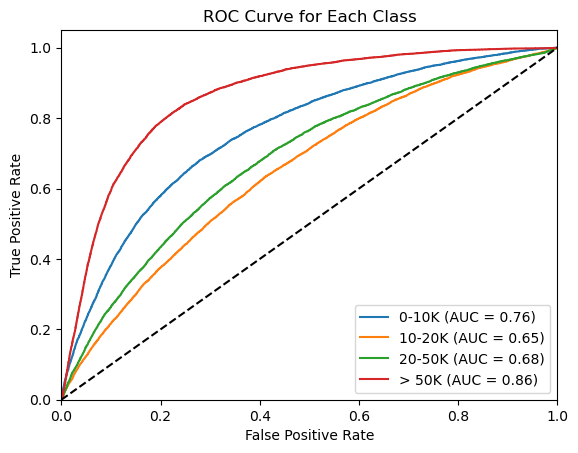

Ordinal Random Forest Model
              precision    recall  f1-score   support

       0-10K       0.46      0.47      0.46     11879
      10-20K       0.39      0.31      0.34     11879
      20-50K       0.37      0.27      0.31     11879
       > 50K       0.50      0.73      0.59     11879

    accuracy                           0.44     47516
   macro avg       0.43      0.44      0.43     47516
weighted avg       0.43      0.44      0.43     47516

ROC-AUC Score: 0.7020456427993029


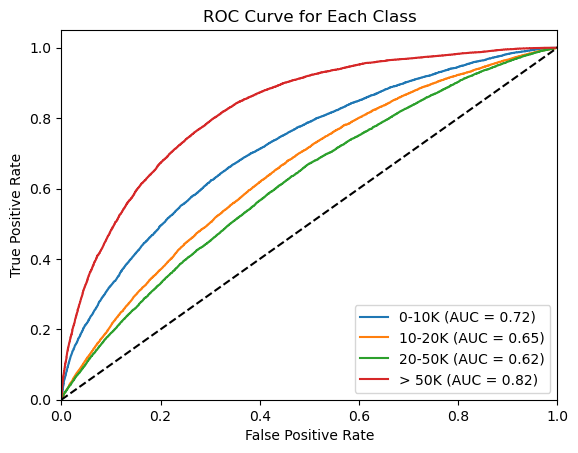

Ordinal Gradient Boosting Model
              precision    recall  f1-score   support

       0-10K       0.51      0.47      0.49     11879
      10-20K       0.43      0.36      0.39     11879
      20-50K       0.41      0.41      0.41     11879
       > 50K       0.64      0.79      0.71     11879

    accuracy                           0.51     47516
   macro avg       0.50      0.51      0.50     47516
weighted avg       0.50      0.51      0.50     47516

ROC-AUC Score: 0.7579700025362841


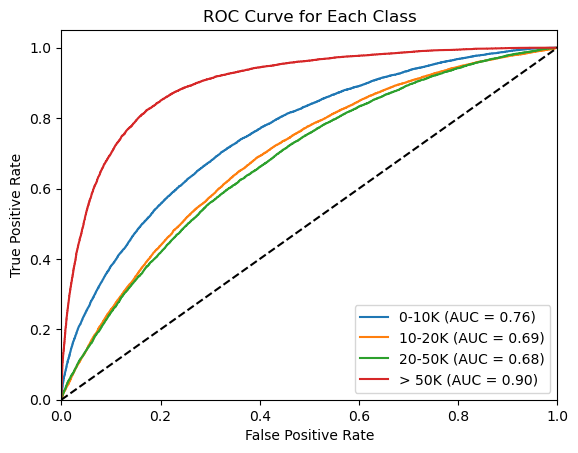

Ordinal LightGBM Model
              precision    recall  f1-score   support

       0-10K       0.51      0.47      0.49     11879
      10-20K       0.43      0.36      0.39     11879
      20-50K       0.41      0.39      0.40     11879
       > 50K       0.62      0.81      0.70     11879

    accuracy                           0.51     47516
   macro avg       0.49      0.51      0.50     47516
weighted avg       0.49      0.51      0.50     47516

ROC-AUC Score: 0.7581105919810353


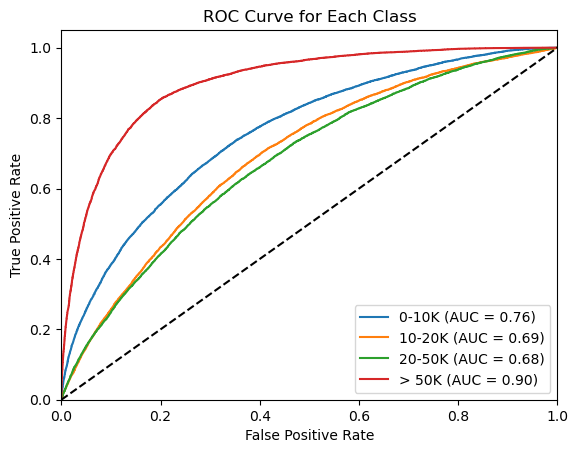

In [10]:
# Model 1: Using Satellite Features Only
print("Ordinal Logistic Regression Model")
ordinal_logistic_model = OrdinalClassifier(clf=LogisticRegression(max_iter=1000, multi_class='ovr', solver='lbfgs'))
cross_val_evaluate_model(ordinal_logistic_model, train_satellite_features_resampled, numeric_train_labels, cv=5, class_labels=list(label_mapping.values()), legend_labels=legend_labels)

print("Ordinal Random Forest Model")
ordinal_rf_model = OrdinalClassifier(clf=RandomForestClassifier(n_estimators=50, max_depth=3, min_samples_split=5, min_samples_leaf=3, random_state=123, n_jobs=-1))
cross_val_evaluate_model(ordinal_rf_model, train_satellite_features_resampled, numeric_train_labels, cv=5, class_labels=list(label_mapping.values()), legend_labels=legend_labels)

print("Ordinal Gradient Boosting Model")
ordinal_gb_model = OrdinalClassifier(clf=GradientBoostingClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, subsample=0.8, random_state=123))
cross_val_evaluate_model(ordinal_gb_model, train_satellite_features_resampled, numeric_train_labels, cv=5, class_labels=list(label_mapping.values()), legend_labels=legend_labels)

print("Ordinal LightGBM Model")
ordinal_lgb_model = OrdinalClassifier(clf=LGBMClassifier(objective='binary', n_estimators=50, max_depth=3, subsample=0.8, random_state=123, learning_rate=0.1, verbosity=-1, n_jobs=-1))
cross_val_evaluate_model(ordinal_lgb_model, train_satellite_features_resampled, numeric_train_labels, cv=5, class_labels=list(label_mapping.values()), legend_labels=legend_labels)

Model 2: Street View Features Only
Ordinal Logistic Regression Model
              precision    recall  f1-score   support

       0-10K       0.49      0.47      0.48     11879
      10-20K       0.37      0.28      0.32     11879
      20-50K       0.38      0.42      0.40     11879
       > 50K       0.55      0.66      0.60     11879

    accuracy                           0.46     47516
   macro avg       0.45      0.46      0.45     47516
weighted avg       0.45      0.46      0.45     47516

ROC-AUC Score: 0.7149730236620969


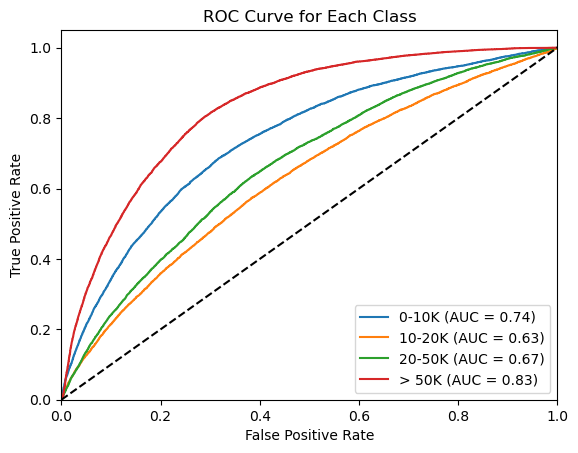

Ordinal Random Forest Model
              precision    recall  f1-score   support

       0-10K       0.41      0.43      0.42     11879
      10-20K       0.38      0.25      0.30     11879
      20-50K       0.33      0.24      0.28     11879
       > 50K       0.46      0.72      0.56     11879

    accuracy                           0.41     47516
   macro avg       0.39      0.41      0.39     47516
weighted avg       0.39      0.41      0.39     47516

ROC-AUC Score: 0.683623550520663


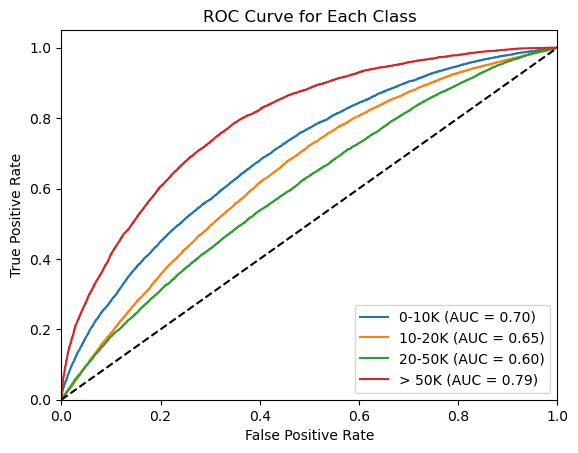

Ordinal Gradient Boosting Model
              precision    recall  f1-score   support

       0-10K       0.49      0.44      0.47     11879
      10-20K       0.42      0.36      0.39     11879
      20-50K       0.41      0.41      0.41     11879
       > 50K       0.62      0.77      0.69     11879

    accuracy                           0.50     47516
   macro avg       0.49      0.50      0.49     47516
weighted avg       0.49      0.50      0.49     47516

ROC-AUC Score: 0.7518723201155799


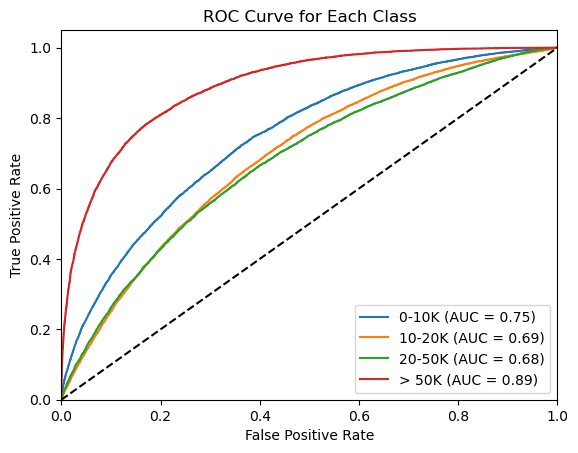

Ordinal LightGBM Model
              precision    recall  f1-score   support

       0-10K       0.48      0.45      0.46     11879
      10-20K       0.42      0.34      0.38     11879
      20-50K       0.41      0.37      0.39     11879
       > 50K       0.59      0.79      0.67     11879

    accuracy                           0.49     47516
   macro avg       0.47      0.49      0.48     47516
weighted avg       0.47      0.49      0.48     47516

ROC-AUC Score: 0.7480859821077088


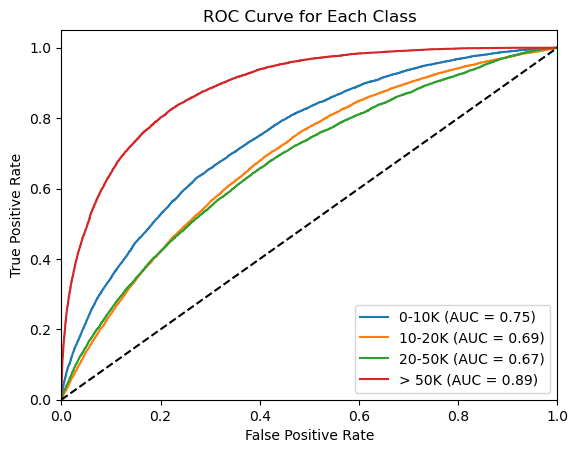

In [12]:
# Model 2: Using Street View Features Only
print("Model 2: Street View Features Only")

print("Ordinal Logistic Regression Model")
cross_val_evaluate_model(ordinal_logistic_model, train_street_features_resampled, numeric_train_labels, cv=5, class_labels=list(label_mapping.values()), legend_labels=legend_labels)

print("Ordinal Random Forest Model")
cross_val_evaluate_model(ordinal_rf_model, train_street_features_resampled, numeric_train_labels, cv=5, class_labels=list(label_mapping.values()), legend_labels=legend_labels)

print("Ordinal Gradient Boosting Model")
cross_val_evaluate_model(ordinal_gb_model, train_street_features_resampled, numeric_train_labels, cv=5, class_labels=list(label_mapping.values()), legend_labels=legend_labels)

print("Ordinal LightGBM Model")
cross_val_evaluate_model(ordinal_lgb_model, train_street_features_resampled, numeric_train_labels, cv=5, class_labels=list(label_mapping.values()), legend_labels=legend_labels)

Model 3: Combined Satellite and Street View Features
Ordinal Logistic Regression Model
              precision    recall  f1-score   support

       0-10K       0.56      0.53      0.54     11879
      10-20K       0.41      0.34      0.37     11879
      20-50K       0.45      0.50      0.47     11879
       > 50K       0.69      0.79      0.74     11879

    accuracy                           0.54     47516
   macro avg       0.53      0.54      0.53     47516
weighted avg       0.53      0.54      0.53     47516

ROC-AUC Score: 0.7798500681461717


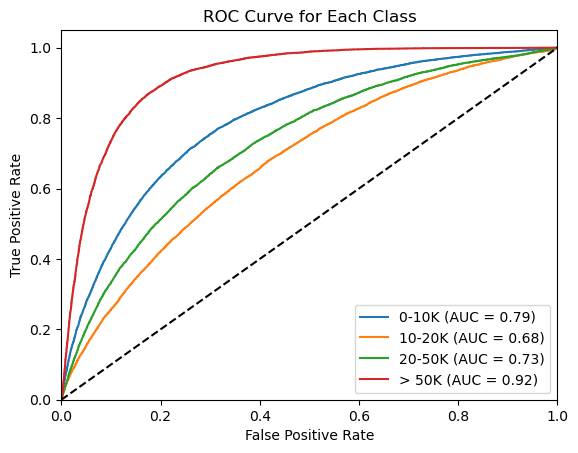

Ordinal Random Forest Model
              precision    recall  f1-score   support

       0-10K       0.47      0.48      0.47     11879
      10-20K       0.39      0.30      0.34     11879
      20-50K       0.38      0.29      0.33     11879
       > 50K       0.52      0.75      0.62     11879

    accuracy                           0.46     47516
   macro avg       0.44      0.46      0.44     47516
weighted avg       0.44      0.46      0.44     47516

ROC-AUC Score: 0.7145526714742936


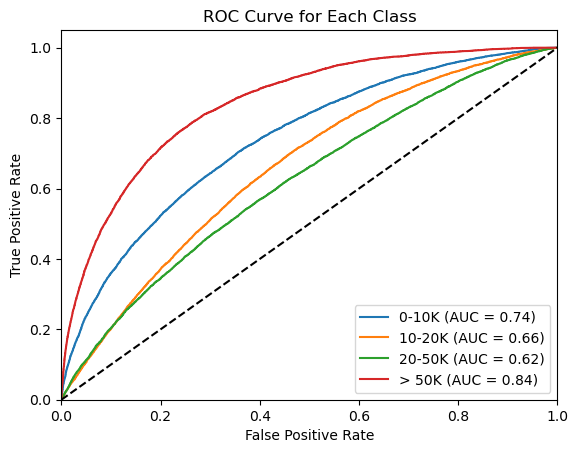

Ordinal Gradient Boosting Model
              precision    recall  f1-score   support

       0-10K       0.53      0.48      0.50     11879
      10-20K       0.42      0.37      0.39     11879
      20-50K       0.43      0.43      0.43     11879
       > 50K       0.67      0.81      0.73     11879

    accuracy                           0.52     47516
   macro avg       0.51      0.52      0.51     47516
weighted avg       0.51      0.52      0.51     47516

ROC-AUC Score: 0.7748816086803829


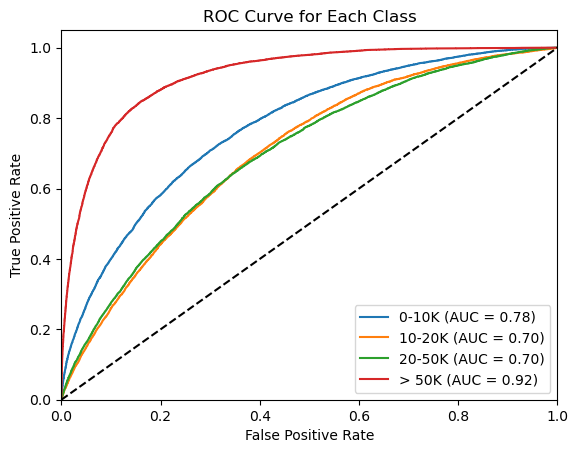

Ordinal LightGBM Model
              precision    recall  f1-score   support

       0-10K       0.53      0.50      0.51     11879
      10-20K       0.44      0.37      0.40     11879
      20-50K       0.43      0.42      0.42     11879
       > 50K       0.65      0.83      0.73     11879

    accuracy                           0.53     47516
   macro avg       0.51      0.53      0.52     47516
weighted avg       0.51      0.53      0.52     47516

ROC-AUC Score: 0.7752519540086751


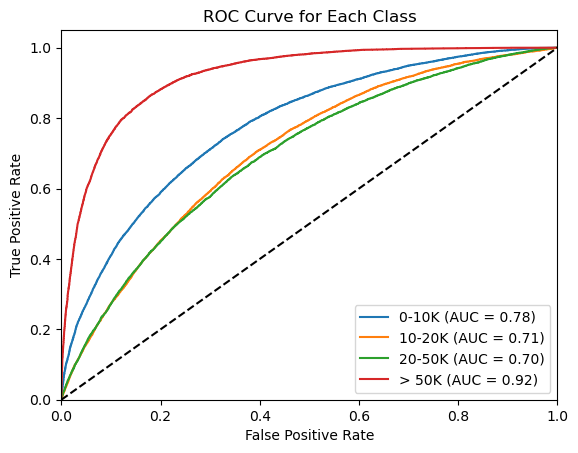

In [13]:
# Model 3: Using Both Satellite and Street View Features
print("Model 3: Combined Satellite and Street View Features")

print("Ordinal Logistic Regression Model")
cross_val_evaluate_model(ordinal_logistic_model, train_combined_features, numeric_train_labels, cv=5, class_labels=list(label_mapping.values()), legend_labels=legend_labels)

print("Ordinal Random Forest Model")
cross_val_evaluate_model(ordinal_rf_model, train_combined_features, numeric_train_labels, cv=5, class_labels=list(label_mapping.values()), legend_labels=legend_labels)

print("Ordinal Gradient Boosting Model")
cross_val_evaluate_model(ordinal_gb_model, train_combined_features, numeric_train_labels, cv=5, class_labels=list(label_mapping.values()), legend_labels=legend_labels)

print("Ordinal LightGBM Model")
cross_val_evaluate_model(ordinal_lgb_model, train_combined_features, numeric_train_labels, cv=5, class_labels=list(label_mapping.values()), legend_labels=legend_labels)